In [14]:
from finlab import login
login('97Y21Yf07Tokqp6rnUxsQKHbc4j+HosTsqE5DNh2oWLA9n+pxaCibJSKUK190ocZ#vip_m')

輸入成功!


In [15]:
import pandas as pd
import numpy as np
from finlab import data

# ======================================
# 0. 參數設定
# ======================================
N_DAYS = 5                # 計算近 N 日漲幅
MIN_LIQ_PCT = 0.6         # 流動性前 60%
TOP_GROUPS = 5           # 每天挑出最強 5 個族群
TOP_STOCKS = 5            # 每個交易日最多選 5 檔股票

# 權重設定 (您可以自由調整這裡的數字)
weights = {
    "ret": 1.5,      # 漲幅權重
    "turnover": 1.0, # 成交額權重
    "inst": 1.0,     # 法人權重
    "conc": 1.0      # 集中度權重
}

# ======================================
# 1. 基礎資料
# ======================================
close = data.get("price:收盤價")
volume = data.get("price:成交股數")

# [新增] 抓取大盤資料 (加權指數)
benchmark = data.get('taiex_total_index:收盤指數')

# 確保抓取到資料再計算
if benchmark is not None and not benchmark.empty:
    # 計算大盤 200MA
    benchmark_ma200 = benchmark.rolling(200).mean()
else:
    # 預防萬一沒抓到資料
    print("Warning: 無法取得大盤資料，將忽略大盤濾網")
    benchmark = pd.Series(dtype=float)
    benchmark_ma200 = pd.Series(dtype=float)

# 族群資料：security_industry_themes 是長表格
theme_raw = data.get("security_industry_themes")

# 法人與主力
foreign = data.get('institutional_investors_trading_summary:外資自營商買賣超股數')
trust = data.get('institutional_investors_trading_summary:投信買賣超股數')
dealer = data.get('institutional_investors_trading_summary:自營商買賣超股數(自行買賣)')

# 建立「股票 → 族群」對應表
# 1. 取出每個 stock_id 最新的一筆資料 (假設 key_date 是資料日期)
if 'key_date' in theme_raw.columns:
    theme = theme_raw.sort_values("key_date").groupby("stock_id").last()
else:
    # 如果沒有日期，直接去重
    theme = theme_raw.drop_duplicates("stock_id", keep="last").set_index("stock_id")

# 2. 解析 category 欄位 (字串 "['水泥', ...]")，取第一個當作主族群
def parse_category(cat_str):
    try:
        # 去除括號與引號，取第一個
        # 例如 "['水泥', '...']" -> "水泥"
        return cat_str.replace("[", "").replace("]", "").split(",")[0].strip("' \"")
    except:
        return "Unknown"

if 'category' in theme.columns:
    theme["main_category"] = theme["category"].apply(parse_category)
    group_mapper = theme["main_category"]
else:
    print("Warning: 'category' column not found in theme_raw")
    group_mapper = pd.Series()

# 計算交集 (修正：不直接與 theme_raw.columns 取交集)
common_cols = (
    close.columns
    .intersection(volume.columns)
    .intersection(foreign.columns)
    .intersection(trust.columns)
    .intersection(dealer.columns)
    .intersection(group_mapper.index)  # 確保有族群分類
)

# 只保留有價格資料的股票，其他資料跟著對齊
close = close[common_cols]
volume = volume[common_cols]
foreign = foreign[common_cols]
trust = trust[common_cols]
dealer = dealer[common_cols]
group_mapper = group_mapper[common_cols]

# ======================================
# 2. 計算每日因子
# ======================================

# -- 2.1 近 N 日漲幅
ret = close.pct_change(N_DAYS)

# -- 2.2 流動性：成交金額
turnover = close * volume

# -- 2.3 前一日法人買超（外資為例）
inst_total = foreign + trust + dealer
inst_buy_yday = inst_total.shift(1)

# -- 2.4 主力集中度（主力買賣超 / 當日成交量）
inst_concentration = inst_total / volume.replace(0, np.nan)

# ======================================
# 3. 計算「族群強度」：漲幅 + 量 + 法人 + 主力
# ======================================
# 按照 group_mapper（Series：index=股票，value=族群名）做欄方向 groupby

group_ret = ret.groupby(group_mapper, axis=1).mean()            # 族群平均漲幅
group_turnover = turnover.groupby(group_mapper, axis=1).sum()   # 族群總成交額
group_inst = inst_buy_yday.groupby(group_mapper, axis=1).sum()  # 族群總法人買超
group_conc = inst_concentration.groupby(group_mapper, axis=1).mean()  # 族群平均主力集中度

# 計算加權分數
group_score = (
      group_ret.rank(axis=1, pct=True) * weights["ret"]
    + group_turnover.rank(axis=1, pct=True) * weights["turnover"]
    + group_inst.rank(axis=1, pct=True) * weights["inst"]
    + group_conc.rank(axis=1, pct=True) * weights["conc"]
)

# 每天挑出最強 TOP_GROUPS 個族群
top_groups_daily = group_score.rank(axis=1, ascending=False) <= TOP_GROUPS

# ======================================
# 4. 在強勢族群中挑個股（四條件）
# ======================================
selected_stocks = {}  # {日期: [股票列表]}

for date in close.index:

    if date not in top_groups_daily.index:
        continue

    # 1️⃣ 這一天最強的族群名稱
    strong_groups_mask = top_groups_daily.loc[date]
    strong_groups = strong_groups_mask[strong_groups_mask].index.tolist()
    if len(strong_groups) == 0:
        continue

    # 2️⃣ 這些族群底下的股票（用 group_mapper 反查）
    stocks_in_groups = group_mapper[group_mapper.isin(strong_groups)].index.tolist()
    if len(stocks_in_groups) == 0:
        continue
    
    # [新增] 檢查日期是否存在於所有需要的 DataFrame 中，避免 KeyError
    if date not in inst_buy_yday.index or date not in inst_concentration.index:
        continue

    # 3️⃣ 把這些股票當天的四個因子抓出來
    df = pd.DataFrame({
        "ret": ret.loc[date, stocks_in_groups],
        "turnover": turnover.loc[date, stocks_in_groups],
        "inst": inst_buy_yday.loc[date, stocks_in_groups],
        "conc": inst_concentration.loc[date, stocks_in_groups]
    }).dropna()

    if df.empty:
        continue

    # 4️⃣ 條件過濾
    # (a) 流動性在前 MIN_LIQ_PCT（例如前 60% 最大成交額）
    liq_cut = df["turnover"].quantile(1 - MIN_LIQ_PCT)
    df = df[df["turnover"] >= liq_cut]

    # (b) 前一日法人買超 > 0
    df = df[df["inst"] > 0]

    # (c) 主力集中度為正（主力買超佔成交量為正）
    df = df[df["conc"] > 0]

    if df.empty:
        continue

    # 5️⃣ 個股綜合分數（跟族群一樣，用 rank 組合）
    df["score"] = (
        df["ret"].rank(pct=True) * weights["ret"]
        + df["turnover"].rank(pct=True) * weights["turnover"]
        + df["inst"].rank(pct=True) * weights["inst"]
        + df["conc"].rank(pct=True) * weights["conc"]
    )

    df = df.sort_values("score", ascending=False).head(TOP_STOCKS)
    selected_stocks[date] = df.index.tolist()

# ======================================
# 5. 結果：每天的選股清單
# ======================================

C:\Users\teraw_rp58jwl\AppData\Local\Temp\ipykernel_205328\424366977.py:95: FutureWarning: The default fill_method='pad' in FinlabDataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = close.pct_change(N_DAYS)
C:\Users\teraw_rp58jwl\AppData\Local\Temp\ipykernel_205328\424366977.py:112: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  group_ret = ret.groupby(group_mapper, axis=1).mean()            # 族群平均漲幅
C:\Users\teraw_rp58jwl\AppData\Local\Temp\ipykernel_205328\424366977.py:113: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  group_turnover = turnover.groupby(group_mapper, axis=1).sum()   # 族群總成交額
C:\Users\teraw_rp58jwl\AppData\Local\Temp\ipykernel_205328\424366977.py:114: FutureWarning: DataFrame.groupby with axis

In [16]:
# ======================================
# 5. 結果呈現：轉成 DataFrame 並加上名稱與產業
# ======================================
# 1. 將字典轉為 DataFrame，索引為日期
df_selected = pd.DataFrame.from_dict(selected_stocks, orient='index').sort_index()

# 2. 定義轉換函數：將代號轉為 "代號 名稱 (產業)"
def get_display_info(stock_id):
    if pd.isna(stock_id):
        return ""
    
    stock_id = str(stock_id)
    if stock_id in theme.index:
        row = theme.loc[stock_id]
        name = row['name'] if 'name' in row else ''
        # main_category 是我們在上一步解析出來的
        category = row['main_category'] if 'main_category' in row else ''
        return f"{stock_id} {name} ({category})"
    else:
        return stock_id

# 3. 套用轉換
df_display = df_selected.applymap(get_display_info)

# 4. 顯示最近 10 個交易日的選股結果

df_display.to_csv('selected_stocks_all.csv', encoding='utf-8-sig')
df_display.tail(20)

C:\Users\teraw_rp58jwl\AppData\Local\Temp\ipykernel_205328\3383263973.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_display = df_selected.applymap(get_display_info)


,0,1,2,3,4
2025-12-02,2454 聯發科 (半導體),2308 台達電 (LED照明產業),1802 台玻 (印刷電路板),3037 欣興 (印刷電路板),1303 南亞 (印刷電路板)
2025-12-03,1303 南亞 (印刷電路板),3037 欣興 (印刷電路板),2454 聯發科 (半導體),3711 日月光投控 (半導體),1301 台塑 (石化及塑橡膠)
2025-12-04,3037 欣興 (印刷電路板),2308 台達電 (LED照明產業),1303 南亞 (印刷電路板),8039 台虹 (印刷電路板),4979 華星光 (通信網路)
2025-12-05,3081 聯亞 (通信網路),1560 中砂 (電機機械),3167 大量 (鋼鐵),2317 鴻海 (通信網路),9802 鈺齊-KY (其他)
2025-12-08,2408 南亞科 (半導體),2337 旺宏 (半導體),3037 欣興 (印刷電路板),3653 健策 (半導體),3711 日月光投控 (半導體)
2025-12-09,8299 群聯 (半導體),2404 漢唐 (其他),2408 南亞科 (半導體),2337 旺宏 (半導體),3105 穩懋 (半導體)
2025-12-10,8358 金居 (印刷電路板),3037 欣興 (印刷電路板),2404 漢唐 (其他),1785 光洋科 (其他),2345 智邦 (通信網路)
2025-12-11,2345 智邦 (通信網路),2404 漢唐 (其他),8358 金居 (印刷電路板),3715 定穎投控 (印刷電路板),1785 光洋科 (其他)
2025-12-12,2404 漢唐 (其他),1785 光洋科 (其他),2059 川湖 (其他),3211 順達 (能源元件),6196 帆宣 (其他)
2025-12-15,2345 智邦 (通信網路),2404 漢唐 (其他),2313 華通 (印刷電路板),6139 亞翔 (其他),5439 高技 (印刷電路板)


### 6. 進階回測系統 + 資金分析
執行進階回測策略，包含更完整的交易邏輯：
- **停損機制**：跌幅超過 10% 執行停損。
- **移動停利**：獲利超過 30% 後啟動，若回檔 2% 則停利出場。
- **冷卻期**：同一檔股票進場後 20 天內不再重複進場。
- **資金模擬**：計算總資金佔用與真實投資報酬率 (ROI)。

### 6. 進階回測系統 + 資金分析
執行進階回測策略，包含更完整的交易邏輯：
- **停損機制**：跌幅超過 10% 執行停損。
- **移動停利**：獲利超過 30% 後啟動，若回檔 2% 則停利出場。
- **冷卻期**：同一檔股票進場後 20 天內不再重複進場。
- **資金模擬**：計算總資金佔用與真實投資報酬率 (ROI)。

開始回測，期間: 2008-02-13 ~ 2025-12-29
參數: 停損=0.1, 停利回檔=0.02, 啟動門檻=0.3, 冷卻=20天
總交易次數: 4297
總損益: 7898468
平均報酬率: 1.84%
勝率: 33.23%


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,highest_reached
4292,3653,2025-12-09,2025-12-17,3015.0,2705.0,Stop Loss (-10.0%),-10524.693300,-0.105766,33,3050.0
4293,1210,2025-04-15,2025-12-18,56.3,50.6,Stop Loss (-10.0%),-10413.984019,-0.104195,1775,66.9
4294,2313,2025-08-15,2025-12-23,78.0,101.5,Trailing Stop (-2.0%),29680.669121,0.297008,1281,104.5
4295,9802,2025-12-08,2025-12-26,114.5,102.5,Stop Loss (-10.0%),-10771.442842,-0.107744,873,114.5
4296,4979,2025-12-05,2025-12-29,237.5,296.0,Trailing Stop (-2.0%),24165.110025,0.242222,420,309.0


\n--- 資金分析 ---
最大資金佔用: 15,491,547 TWD
平均資金佔用: 6,143,686 TWD
真實報酬率 (ROI): 50.99% (以最大資金當分母)


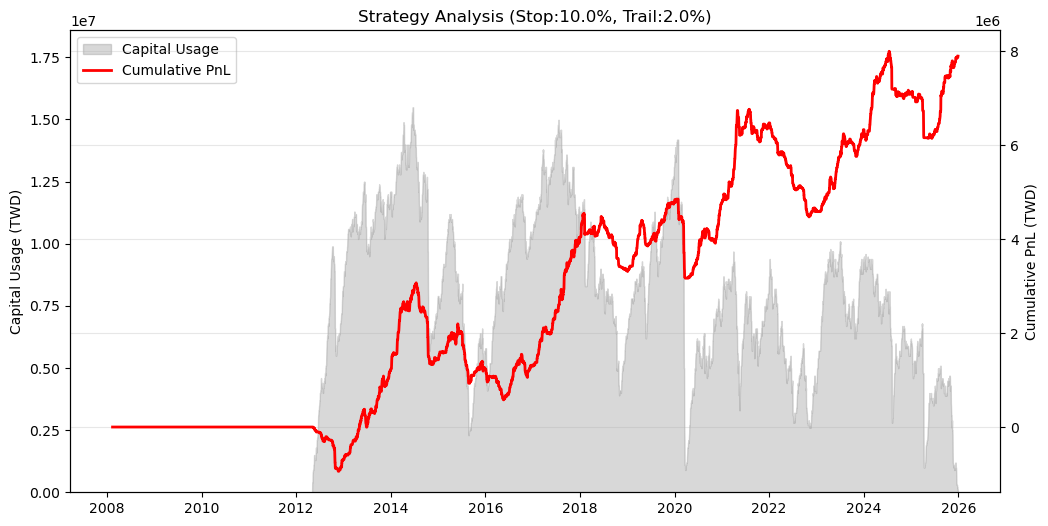

\n========== 目前持倉明細 (未平倉) ==========
持倉檔數: 50
預估未實現總損益: 364,344 TWD


In [5]:
# ======================================
# 6. 進階回測系統 (做多 Long) + 資金分析
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
high_ = data.get("price:最高價")[common_cols]
close_ = close 

# 2. 計算個股 200MA
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
TRAILING_STOP_PCT = 0.02       # 回檔 2% 停利
TRAILING_ACTIVATION_PCT = 0.30 # 獲利 > 30% 才啟動
COOLING_OFF_DAYS = 20          # 冷卻期 20 天
# -------------

# 4. 初始化
positions = []       
trade_history = []   
last_selected_date = {} 

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測，期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT}, 停利回檔={TRAILING_STOP_PCT}, 啟動門檻={TRAILING_ACTIVATION_PCT}, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        current_high = high_.at[today, stock_id]
        
        # 1. 更新最高價
        if current_high > pos['highest_price']:
            pos['highest_price'] = current_high
            
        exit_reason = None
        
        # 2. 停損檢查
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 3. 移動停利檢查
        activation_price = pos['entry_price'] * (1 + TRAILING_ACTIVATION_PCT)
        
        if pos['highest_price'] >= activation_price:
            stop_price = pos['highest_price'] * (1 - TRAILING_STOP_PCT)
            if current_close < stop_price:
                exit_reason = f"Trailing Stop (-{TRAILING_STOP_PCT*100}%)"
            
        if exit_reason:
            # 賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'highest_reached': pos['highest_price']
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [移除] 大盤濾網相關邏輯，直接從 signal_dict 取得候選股票
    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_price': entry_price,
                'highest_price': entry_price, 
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果呈現與資金分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    # 1. 基礎績效
    print(f"總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    
    display(df_trades.tail(5))
    
    # 2. 資金佔用分析
    date_range = pd.date_range(start=backtest_dates[0], end=backtest_dates[-1])
    daily_capital = pd.Series(0, index=date_range).astype(float)
    
    for _, row in df_trades.iterrows():
        trade_capital = row['entry_price'] * row['shares']
        if row['entry_date'] == row['exit_date']:
            daily_capital[row['entry_date']] += trade_capital
        else:
            end_date = row['exit_date'] - pd.Timedelta(days=1)
            daily_capital[row['entry_date']:end_date] += trade_capital

    max_capital = daily_capital.max()
    avg_capital = daily_capital.mean()
    total_profit = df_trades['pnl'].sum()
    roi = total_profit / max_capital if max_capital > 0 else 0

    print(f"\\n--- 資金分析 ---")
    print(f"最大資金佔用: {max_capital:,.0f} TWD")
    print(f"平均資金佔用: {avg_capital:,.0f} TWD")
    print(f"真實報酬率 (ROI): {roi * 100:.2f}% (以最大資金當分母)")

    # 3. 繪圖 (資金佔用 + 權益曲線)
    import matplotlib.pyplot as plt
    
    # 準備權益曲線數據
    df_trades = df_trades.sort_values("exit_date")
    daily_pnl = pd.Series(0, index=date_range).astype(float)
    pnl_by_date = df_trades.groupby("exit_date")["pnl"].sum()
    daily_pnl = daily_pnl.add(pnl_by_date, fill_value=0)
    cumulative_pnl = daily_pnl.cumsum()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 繪製資金佔用 (灰色區域)
    ax1.fill_between(daily_capital.index, daily_capital, color="gray", alpha=0.3, label="Capital Usage")
    ax1.set_ylabel("Capital Usage (TWD)")
    ax1.set_ylim(0, max_capital * 1.2)

    # 繪製累積損益 (紅線)
    ax2 = ax1.twinx()
    ax2.plot(cumulative_pnl.index, cumulative_pnl, color="red", linewidth=2, label="Cumulative PnL")
    ax2.set_ylabel("Cumulative PnL (TWD)")

    plt.title(f"Strategy Analysis (Stop:{STOP_LOSS_PCT*100}%, Trail:{TRAILING_STOP_PCT*100}%)")
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 4. 顯示目前持倉
    if len(positions) > 0:
        print("\\n========== 目前持倉明細 (未平倉) ==========")
        current_holdings = []
        last_date = backtest_dates[-1]
        
        for pos in positions:
            stock_id = pos['stock_id']
            if last_date in close_.index and not pd.isna(close_.at[last_date, stock_id]):
                current_price = close_.at[last_date, stock_id]
            else:
                current_price = pos['highest_price']

            market_value = current_price * pos['shares']
            est_sell_cost = market_value * (FEE_RATE + TAX_RATE)
            unrealized_pnl = market_value - est_sell_cost - pos['cost']
            ret_pct = unrealized_pnl / pos['cost']
            
            try:
                name_info = get_display_info(stock_id)
            except:
                name_info = str(stock_id)
                
            current_holdings.append({
                '代號': stock_id,
                '名稱': name_info,
                '進場日期': pos['entry_date'].date(),
                '進場價': pos['entry_price'],
                '現價': current_price,
                '股數': pos['shares'],
                '成本': round(pos['cost']),
                '市值': round(market_value),
                '未實現損益': round(unrealized_pnl),
                '報酬率%': round(ret_pct * 100, 2),
                '最高價': pos['highest_price']
            })
            
        df_holdings = pd.DataFrame(current_holdings)
        print(f"持倉檔數: {len(df_holdings)}")
        print(f"預估未實現總損益: {df_holdings['未實現損益'].sum():,.0f} TWD")
        pd.set_option('display.max_rows', None)
        #display(df_holdings)
    else:
        print("\\n目前無任何持倉")

else:
    print("無交易紀錄")

開始回測，期間: 2008-02-13 ~ 2025-12-29
參數: 停損=0.1, 停利回檔=0.03, 啟動門檻=0.2, 冷卻=20天, 時間強制出場=25天
總交易次數: 5527
總損益: 3032471
平均報酬率: 0.55%
勝率: 46.08%


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,highest_reached
5517,3443,2025-11-12,2025-12-17,1990.00,2010.00,Time Exit (25 days),670.000000,0.006733,50,2330.0
5518,2308,2025-12-03,2025-12-17,997.00,890.00,Stop Loss (-10.0%),-10993.889750,-0.110254,100,1005.0
5519,3653,2025-12-09,2025-12-17,3015.00,2705.00,Stop Loss (-10.0%),-10524.693300,-0.105766,33,3050.0
5520,5439,2025-11-17,2025-12-22,320.00,318.50,Time Exit (25 days),-794.503710,-0.007957,312,380.0
5521,3105,2025-12-10,2025-12-23,167.00,188.50,Trailing Stop (-3.0%),12488.537068,0.125035,598,203.0
5522,3211,2025-12-15,2025-12-24,278.00,323.50,Trailing Stop (-3.0%),15955.319264,0.159847,359,345.0
5523,2312,2025-11-20,2025-12-26,22.30,22.65,Time Exit (25 days),1235.714854,0.012359,4483,24.6
5524,9802,2025-12-08,2025-12-26,114.50,102.50,Stop Loss (-10.0%),-10771.442842,-0.107744,873,114.5
5525,2885,2025-11-21,2025-12-29,35.65,39.85,Time Exit (25 days),11411.414265,0.114141,2804,40.8
5526,4979,2025-12-05,2025-12-29,237.50,296.00,Trailing Stop (-3.0%),24165.110025,0.242222,420,309.0



--- 資金分析 ---
最大資金佔用: 5,796,470 TWD
平均資金佔用: 2,399,964 TWD
真實報酬率 (ROI): 52.32% (以最大資金當分母)


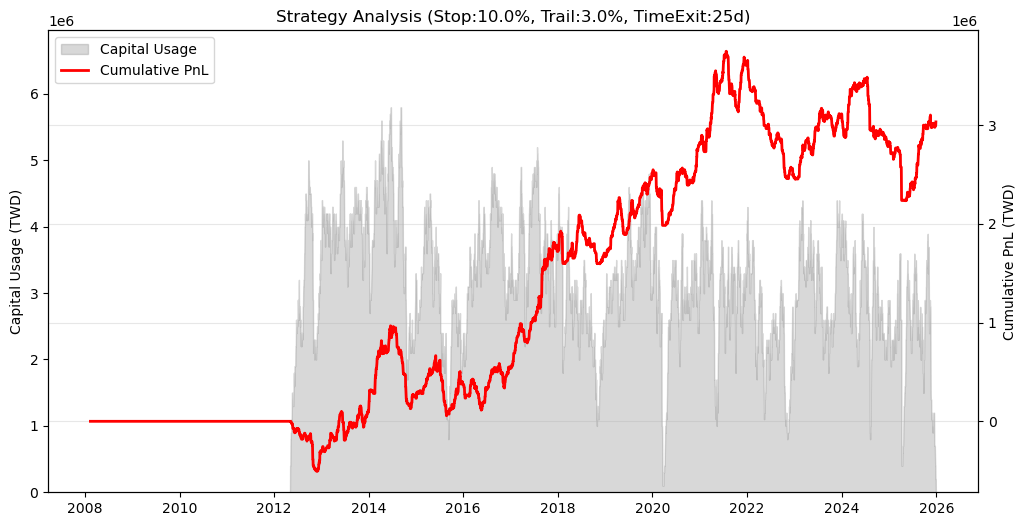


========== 目前持倉明細 (未平倉) ==========
持倉檔數: 20
預估未實現總損益: 67,601 TWD


,代號,名稱,進場日期,進場價,現價,股數,成本,市值,未實現損益,報酬率%,持有天數
0,2823,2823 中壽 (金融),2021-11-19,31.10,31.10,3214,99970,99955,-328,-0.33,997
1,5469,5469 瀚宇博 (印刷電路板),2025-11-26,97.40,94.40,1026,99947,96854,-3397,-3.40,22
2,3481,3481 群創 (平面顯示器),2025-11-28,13.60,14.85,7351,99988,109162,8831,8.83,20
3,2454,2454 聯發科 (半導體),2025-12-02,1445.00,1420.00,69,99719,97980,-2047,-2.05,18
4,3711,3711 日月光投控 (半導體),2025-12-02,228.50,251.00,437,99869,109687,9474,9.49,18
5,3037,3037 欣興 (印刷電路板),2025-12-03,197.00,220.50,507,99893,111794,11549,11.56,17
6,1560,1560 中砂 (電機機械),2025-12-08,344.00,377.50,290,99774,109475,9357,9.38,14
7,3167,3167 大量 (鋼鐵),2025-12-08,222.00,240.00,450,99914,108000,7746,7.75,14
8,2337,2337 旺宏 (半導體),2025-12-09,37.60,38.15,2659,99993,101441,1129,1.13,13
9,2404,2404 漢唐 (其他),2025-12-10,845.00,922.00,118,99724,108796,8730,8.75,12


In [6]:
# ======================================
# 6. 進階回測系統 (做多 Long) + 資金分析 (含時間停損)
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
high_ = data.get("price:最高價")[common_cols]
close_ = close

# 2. 計算個股 200MA
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
TRAILING_STOP_PCT = 0.03       # 回檔 2% 停利
TRAILING_ACTIVATION_PCT = 0.20 # 獲利 > 30% 才啟動
COOLING_OFF_DAYS = 20          # 冷卻期 20 天
MAX_HOLDING_DAYS = 25          # [新增] 最大持有天數 (20個交易日)強制出場
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測，期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT}, 停利回檔={TRAILING_STOP_PCT}, 啟動門檻={TRAILING_ACTIVATION_PCT}, 冷卻={COOLING_OFF_DAYS}天, 時間強制出場={MAX_HOLDING_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]

    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']

        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue

        current_close = close_.at[today, stock_id]
        current_high = high_.at[today, stock_id]

        # 1. 更新最高價
        if current_high > pos['highest_price']:
            pos['highest_price'] = current_high

        exit_reason = None

        # 2. 停損檢查
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"

        # 3. 移動停利檢查
        activation_price = pos['entry_price'] * (1 + TRAILING_ACTIVATION_PCT)

        if pos['highest_price'] >= activation_price:
            stop_price = pos['highest_price'] * (1 - TRAILING_STOP_PCT)
            if current_close < stop_price:
                exit_reason = f"Trailing Stop (-{TRAILING_STOP_PCT*100}%)"

        # 4. [新增] 時間強制出場
        # 計算持有交易日數 (目前 index - 進場 index)
        held_days = i - pos['entry_idx']
        if exit_reason is None and held_days >= MAX_HOLDING_DAYS:
            exit_reason = f"Time Exit ({MAX_HOLDING_DAYS} days)"

        if exit_reason:
            # 賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']

            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'highest_reached': pos['highest_price']
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---

    candidates = signal_dict.get(yesterday, [])

    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue

        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue

        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass

        last_selected_date[stock_id] = yesterday

        if not is_first_in_period:
            continue

        if any(p['stock_id'] == stock_id for p in positions):
            continue

        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))

        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)

            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i,  # [新增] 紀錄進場當日的 index 以計算持有天數
                'entry_price': entry_price,
                'highest_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果呈現與資金分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    # 1. 基礎績效
    print(f"總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")

    display(df_trades.tail(10))

    # 2. 資金佔用分析
    date_range = pd.date_range(start=backtest_dates[0], end=backtest_dates[-1])
    daily_capital = pd.Series(0, index=date_range).astype(float)

    for _, row in df_trades.iterrows():
        trade_capital = row['entry_price'] * row['shares']
        if row['entry_date'] == row['exit_date']:
            daily_capital[row['entry_date']] += trade_capital
        else:
            end_date = row['exit_date'] - pd.Timedelta(days=1)
            daily_capital[row['entry_date']:end_date] += trade_capital

    max_capital = daily_capital.max()
    avg_capital = daily_capital.mean()
    total_profit = df_trades['pnl'].sum()
    roi = total_profit / max_capital if max_capital > 0 else 0

    print(f"\n--- 資金分析 ---")
    print(f"最大資金佔用: {max_capital:,.0f} TWD")
    print(f"平均資金佔用: {avg_capital:,.0f} TWD")
    print(f"真實報酬率 (ROI): {roi * 100:.2f}% (以最大資金當分母)")

    # 3. 繪圖 (資金佔用 + 權益曲線)
    import matplotlib.pyplot as plt

    # 準備權益曲線數據
    df_trades = df_trades.sort_values("exit_date")
    daily_pnl = pd.Series(0, index=date_range).astype(float)
    pnl_by_date = df_trades.groupby("exit_date")["pnl"].sum()
    daily_pnl = daily_pnl.add(pnl_by_date, fill_value=0)
    cumulative_pnl = daily_pnl.cumsum()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 繪製資金佔用 (灰色區域)
    ax1.fill_between(daily_capital.index, daily_capital, color="gray", alpha=0.3, label="Capital Usage")
    ax1.set_ylabel("Capital Usage (TWD)")
    ax1.set_ylim(0, max_capital * 1.2)

    # 繪製累積損益 (紅線)
    ax2 = ax1.twinx()
    ax2.plot(cumulative_pnl.index, cumulative_pnl, color="red", linewidth=2, label="Cumulative PnL")
    ax2.set_ylabel("Cumulative PnL (TWD)")

    plt.title(f"Strategy Analysis (Stop:{STOP_LOSS_PCT*100}%, Trail:{TRAILING_STOP_PCT*100}%, TimeExit:{MAX_HOLDING_DAYS}d)")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. 顯示目前持倉
    if len(positions) > 0:
        print("\n========== 目前持倉明細 (未平倉) ==========")
        current_holdings = []
        last_date = backtest_dates[-1]
        last_idx = len(backtest_dates) - 1

        for pos in positions:
            stock_id = pos['stock_id']
            if last_date in close_.index and not pd.isna(close_.at[last_date, stock_id]):
                current_price = close_.at[last_date, stock_id]
            else:
                current_price = pos['highest_price']

            market_value = current_price * pos['shares']
            est_sell_cost = market_value * (FEE_RATE + TAX_RATE)
            unrealized_pnl = market_value - est_sell_cost - pos['cost']
            ret_pct = unrealized_pnl / pos['cost']

            try:
                name_info = get_display_info(stock_id)
            except:
                name_info = str(stock_id)
            
            # 計算目前持有天數
            current_held_days = last_idx - pos['entry_idx']

            current_holdings.append({
                '代號': stock_id,
                '名稱': name_info,
                '進場日期': pos['entry_date'].date(),
                '進場價': pos['entry_price'],
                '現價': current_price,
                '股數': pos['shares'],
                '成本': round(pos['cost']),
                '市值': round(market_value),
                '未實現損益': round(unrealized_pnl),
                '報酬率%': round(ret_pct * 100, 2),
                '持有天數': current_held_days
            })

        df_holdings = pd.DataFrame(current_holdings)
        print(f"持倉檔數: {len(df_holdings)}")
        print(f"預估未實現總損益: {df_holdings['未實現損益'].sum():,.0f} TWD")
        pd.set_option('display.max_rows', None)
        display(df_holdings)
    else:
        print("\n目前無任何持倉")

else:
    print("無交易紀錄")

### 8. 進場後漲幅特性分析
本單元分析股票進場後的表現，統計在觀察期間內（如 60 天）的最高漲幅及其發生的時間點，協助評估策略的潛在獲利空間與持倉時間。

### 8. 進場後漲幅特性分析
本單元分析股票進場後的表現，統計在觀察期間內（如 60 天）的最高漲幅及其發生的時間點，協助評估策略的潛在獲利空間與持倉時間。

In [7]:
# ======================================
# 8. 進場後漲幅特性分析 (尋找最高點發生的時間)
# ======================================
import numpy as np

# 1. 分析參數
OBSERVATION_WINDOW = 60    # 觀察視窗：進場後 60 天內 (可自行修改，例如 20, 60, 120)
ANALYSIS_COOLING_DAYS = 20 # 依照策略冷卻期

# 2. 變數初始化
days_to_peak_list = []
max_gain_list = []
analyzed_count = 0

analysis_last_selected = {}

print(f"開始分析... (觀察進場後 {OBSERVATION_WINDOW} 日內的表現)")

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        # A. 資料與策略濾網
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # B. 冷卻期
        last_date = analysis_last_selected.get(stock_id)
        is_cooldown = False
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= ANALYSIS_COOLING_DAYS:
                    is_cooldown = True
            except:
                pass
        
        if is_cooldown:
            continue
            
        analysis_last_selected[stock_id] = yesterday
        analyzed_count += 1
        
        entry_price = open_.at[today, stock_id]
        
        # C. 取得觀察期間的股價數據
        # 從 today 開始往後取 OBSERVATION_WINDOW 天
        # 注意：一定要包含今天的數據
        try:
            # 取得當天在 index 的位置
            start_pos = high_.index.get_loc(today)
            end_pos = min(start_pos + OBSERVATION_WINDOW, len(high_))
            
            # 取出這段期間的最高價序列
            period_highs = high_.iloc[start_pos:end_pos][stock_id]
            
            if period_highs.empty:
                continue

            # 找出期間最高價及其日期
            max_price = period_highs.max()
            max_date = period_highs.idxmax()
            
            # 計算數據
            gain_pct = (max_price - entry_price) / entry_price
            
            # 計算距離進場第幾天 (交易日)
            # max_date 的 index 位置 - entry_date(today) 的 index 位置
            days_to_peak = high_.index.get_loc(max_date) - start_pos
            
            max_gain_list.append(gain_pct)
            days_to_peak_list.append(days_to_peak)
            
        except Exception as e:
            # 防止數據不足出錯
            continue

# ======================================
# 結果統計
# ======================================
print(f"\n===== 分析結果 (共模擬 {analyzed_count} 次進場) =====")
print(f"觀察視窗: {OBSERVATION_WINDOW} 個交易日")

if len(days_to_peak_list) > 0:
    avg_days = np.mean(days_to_peak_list)
    median_days = np.median(days_to_peak_list)
    avg_gain = np.mean(max_gain_list)
    median_gain = np.median(max_gain_list)
    
    print(f"\n[最高點發生時間]")
    print(f"  - 平均在第 {avg_days:.1f} 天")
    print(f"  - 中位數在第 {median_days:.0f} 天")
    
    print(f"\n[期間最大漲幅]")
    print(f"  - 平均最大漲幅: {avg_gain*100:.2f}%")
    print(f"  - 中位數漲幅  : {median_gain*100:.2f}%")
    
    # 進階：簡單分佈觀察
    print(f"\n[分佈狀況]")
    print(f"  - 5天內創高比例 : {np.mean(np.array(days_to_peak_list) <= 5)*100:.1f}%")
    print(f"  - 10天內創高比例: {np.mean(np.array(days_to_peak_list) <= 10)*100:.1f}%")
    print(f"  - 20天內創高比例: {np.mean(np.array(days_to_peak_list) <= 20)*100:.1f}%")

else:
    print("無有效樣本")

開始分析... (觀察進場後 60 日內的表現)

===== 分析結果 (共模擬 6114 次進場) =====
觀察視窗: 60 個交易日

[最高點發生時間]
  - 平均在第 25.8 天
  - 中位數在第 23 天

[期間最大漲幅]
  - 平均最大漲幅: 20.15%
  - 中位數漲幅  : 12.64%

[分佈狀況]
  - 5天內創高比例 : 25.4%
  - 10天內創高比例: 34.4%
  - 20天內創高比例: 47.4%


### 9. 固定持有期策略回測
執行基礎回測策略：
- **停損機制**：跌幅超過 10% 執行停損。
- **固定持有**：若未觸及停損，持有 40 天後強制出場。
- **冷卻期**：同一檔股票進場後 5 天內不再重複進場。

### 9. 固定持有期策略回測
執行基礎回測策略：
- **停損機制**：跌幅超過 10% 執行停損。
- **固定持有**：若未觸及停損，持有 40 天後強制出場。
- **冷卻期**：同一檔股票進場後 5 天內不再重複進場。

開始回測 (固定持有策略)
期間: 2008-02-13 ~ 2025-12-29
參數: 停損=10.0%, 固定持有=40天, 冷卻=5天

總交易次數: 7262
總損益: 11,705,600
平均報酬率: 1.61%
勝率: 42.14%
平均持有天數: 30.4 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
7252,2308,2025-12-03,2025-12-17,997.0,890.00,Stop Loss (-10.0%),-10993.889750,-0.110254,100,10
7253,3653,2025-12-09,2025-12-17,3015.0,2705.00,Stop Loss (-10.0%),-10524.693300,-0.105766,33,6
7254,3711,2025-10-22,2025-12-18,191.5,222.00,Time Exit (40 days),15542.589803,0.155461,522,40
7255,2472,2025-10-22,2025-12-18,102.5,103.50,Time Exit (40 days),643.641375,0.006440,975,40
7256,3231,2025-10-23,2025-12-19,142.0,144.00,Time Exit (40 days),1075.180480,0.010754,704,40
7257,1301,2025-10-27,2025-12-22,40.8,40.15,Time Exit (40 days),-1915.864169,-0.019164,2450,40
7258,2881,2025-10-29,2025-12-24,91.1,98.00,Time Exit (40 days),7217.221415,0.072208,1097,40
7259,2345,2025-10-30,2025-12-26,987.0,1215.00,Time Exit (40 days),22628.162715,0.226960,101,40
7260,9802,2025-12-08,2025-12-26,114.5,102.50,Stop Loss (-10.0%),-10771.442842,-0.107744,873,13
7261,1519,2025-10-31,2025-12-29,655.0,778.00,Time Exit (40 days),18310.193220,0.183885,152,40


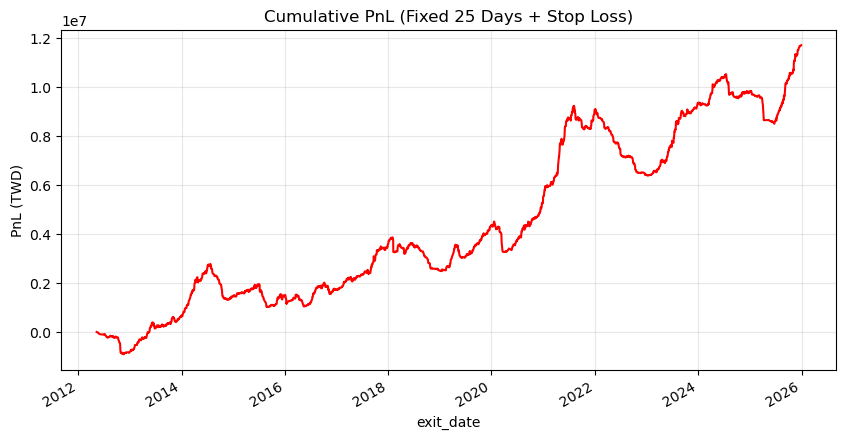

In [8]:
# ======================================
# 9. 固定持有期策略回測 (Fixed Holding + Stop Loss)
# 策略邏輯：
# 1. 買進後持有固定天數 (FIXED_HOLDING_DAYS = 25)
# 2. 期間若觸及停損 (STOP_LOSS_PCT = 10%) 則提前出場
# 3. 若未觸及停損，則在第 25 天收盤價強制出場
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 25 天
COOLING_OFF_DAYS = 5          # 進場冷卻期 20 天
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間 (同前)
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有策略)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
       # if any(p['stock_id'] == stock_id for p in positions):
        #    continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i, # 紀錄 index 以計算天數
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 簡單繪製權益曲線
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title="Cumulative PnL (Fixed 25 Days + Stop Loss)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

### 9. 固定持有期策略 + 大盤濾網
在基礎策略上加入**大盤濾網**：
- 僅在大盤指數位於 200 日均線（年線）之上時才進場做多，以避免在熊市接刀。

### 9. 固定持有期策略 + 大盤濾網
在基礎策略上加入**大盤濾網**：
- 僅在大盤指數位於 200 日均線（年線）之上時才進場做多，以避免在熊市接刀。

開始回測 (固定持有 + 大盤濾網)
期間: 2008-02-13 ~ 2025-12-29
參數: 停損=10.0%, 固定持有=40天, 冷卻=5天

總交易次數: 4468
總損益: 7,589,346
平均報酬率: 1.70%
勝率: 42.41%
平均持有天數: 30.6 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
4458,8358,2025-12-11,2025-12-16,288.0,247.00,Stop Loss (-10.0%),-14510.581413,-0.145178,347,3
4459,2308,2025-12-03,2025-12-17,997.0,890.00,Stop Loss (-10.0%),-10993.889750,-0.110254,100,10
4460,3653,2025-12-09,2025-12-17,3015.0,2705.00,Stop Loss (-10.0%),-10524.693300,-0.105766,33,6
4461,3711,2025-10-22,2025-12-18,191.5,222.00,Time Exit (40 days),15542.589803,0.155461,522,40
4462,2472,2025-10-22,2025-12-18,102.5,103.50,Time Exit (40 days),643.641375,0.006440,975,40
4463,3231,2025-10-23,2025-12-19,142.0,144.00,Time Exit (40 days),1075.180480,0.010754,704,40
4464,1301,2025-10-27,2025-12-22,40.8,40.15,Time Exit (40 days),-1915.864169,-0.019164,2450,40
4465,2345,2025-10-30,2025-12-26,987.0,1215.00,Time Exit (40 days),22628.162715,0.226960,101,40
4466,9802,2025-12-08,2025-12-26,114.5,102.50,Stop Loss (-10.0%),-10771.442842,-0.107744,873,13
4467,1519,2025-10-31,2025-12-29,655.0,778.00,Time Exit (40 days),18310.193220,0.183885,152,40


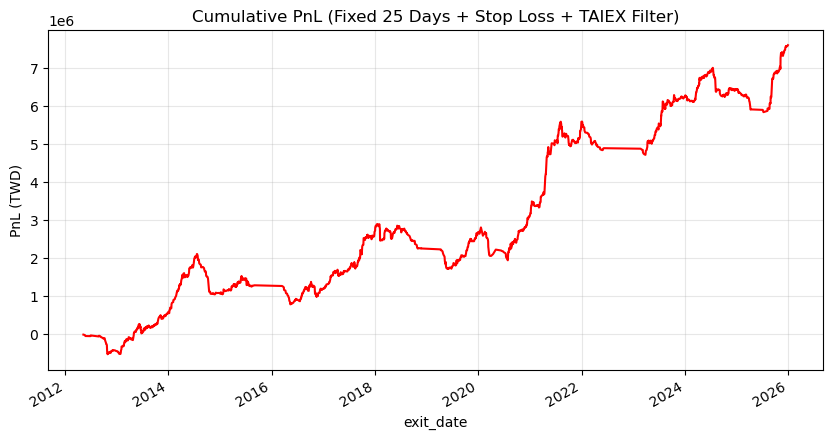

In [9]:
# ======================================
# 9. 固定持有期策略回測 (Fixed Holding + Stop Loss) + 大盤濾網 (修正版)
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# [新增] 抓取大盤資料 (加權指數)
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 25 天
COOLING_OFF_DAYS = 5          # 進場冷卻期 20 天
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間 (同前)
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有 + 大盤濾網)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [修正] 大盤濾網條件
    # 使用 .at 來確保取回的是單一純量值，而非 Series
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        # benchmark 有可能有多個欄位 (雖然看起來像 Series)，為了保險使用 .iloc[0] 或 .item()
        # 或者確保 benchmark 本身是 Series
        
        # 情境 1: benchmark 是 DataFrame
        if isinstance(benchmark, pd.DataFrame):
             bm_val = benchmark.at[yesterday, benchmark.columns[0]]
        else:
             bm_val = benchmark.at[yesterday]
             
        if isinstance(benchmark_ma200, pd.DataFrame):
             ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]]
        else:
             ma_val = benchmark_ma200.at[yesterday]
             
        # 進行比較
        if pd.notna(bm_val) and pd.notna(ma_val):
            if bm_val <= ma_val:
                market_filter_pass = False
    
    # 如果大盤濾網未通過，則今天完全不開新倉
    if not market_filter_pass:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i, # 紀錄 index 以計算天數
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 簡單繪製權益曲線
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title="Cumulative PnL (Fixed 25 Days + Stop Loss + TAIEX Filter)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

### 10. 進場日期分佈統計
統計所有進場訊號的日期分佈，比較「每月前 10 日」與「非前 10 日」的進場數量差異，了解策略是否具有特定時間慣性。

### 10. 進場日期分佈統計
統計所有進場訊號的日期分佈，比較「每月前 10 日」與「非前 10 日」的進場數量差異，了解策略是否具有特定時間慣性。

========== 進場日期統計 (以每月 10 日為界) ==========
總交易次數: 4468
  - 上旬進場 (1-10日) : 1472 次 (32.9%)
  - 中下旬進場 (11-31日): 2996 次 (67.1%)
----------------------------------------
獲利交易總數: 1895
  - 上旬獲利次數: 638 次
  - 上旬獲利佔比: 33.7% (佔所有獲利單)
----------------------------------------
績效比較:
  [1-10日 進場] 勝率: 43.34% | 平均報酬: 2.23%
  [11-31日 進場] 勝率: 41.96% | 平均報酬: 1.44%


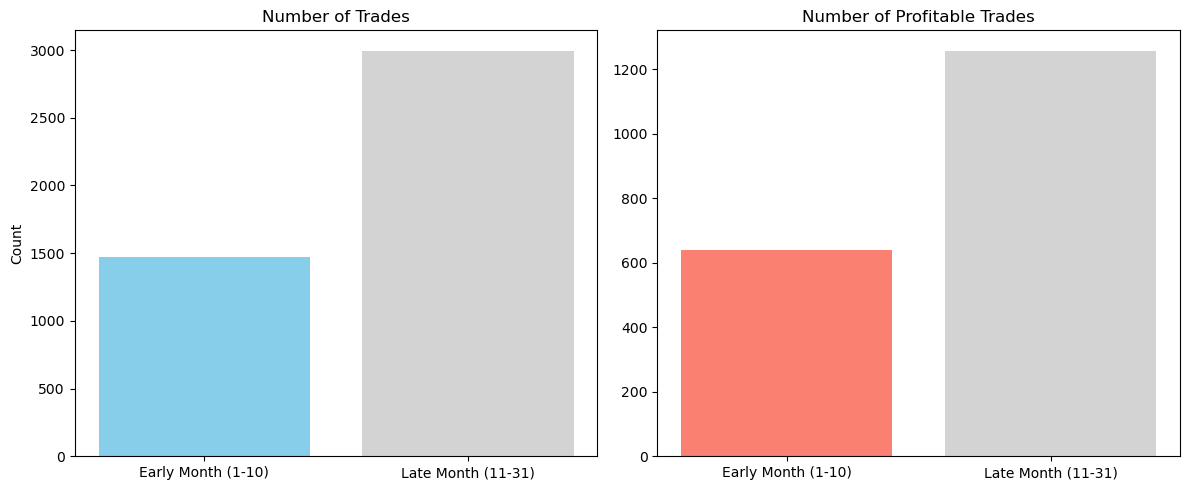

In [10]:
# ======================================
# 10. 進場日期分佈統計 (每月前 10 日 vs 非前 10 日)
# ======================================

if not df_trades.empty:
    # 確保 'entry_date' 是 datetime 格式
    df_trades['entry_date'] = pd.to_datetime(df_trades['entry_date'])
    
    # 1. 建立標籤：是否在每月 10 日 (含) 以前進場
    df_trades['is_early_month'] = df_trades['entry_date'].dt.day <= 10
    
    # 2. 總次數統計
    total_trades = len(df_trades)
    early_month_trades = df_trades['is_early_month'].sum()
    late_month_trades = total_trades - early_month_trades
    
    # 3. 獲利交易統計
    prof_trades = df_trades[df_trades['pnl'] > 0]
    total_prof_trades = len(prof_trades)
    early_month_prof_trades = prof_trades['is_early_month'].sum()
    late_month_prof_trades = total_prof_trades - early_month_prof_trades
    
    # 4. 虧損交易統計
    loss_trades = df_trades[df_trades['pnl'] <= 0]
    total_loss_trades = len(loss_trades)
    early_month_loss_trades = loss_trades['is_early_month'].sum()
    
    # 5. 勝率比較
    win_rate_early = early_month_prof_trades / early_month_trades if early_month_trades > 0 else 0
    win_rate_late = late_month_prof_trades / late_month_trades if late_month_trades > 0 else 0
    
    # 6. 平均報酬比較
    avg_ret_early = df_trades[df_trades['is_early_month']]['return'].mean()
    avg_ret_late = df_trades[~df_trades['is_early_month']]['return'].mean()

    # --- 輸出結果 ---
    print(f"========== 進場日期統計 (以每月 10 日為界) ==========")
    print(f"總交易次數: {total_trades}")
    print(f"  - 上旬進場 (1-10日) : {early_month_trades} 次 ({early_month_trades/total_trades*100:.1f}%)")
    print(f"  - 中下旬進場 (11-31日): {late_month_trades} 次 ({late_month_trades/total_trades*100:.1f}%)")
    print("-" * 40)
    
    print(f"獲利交易總數: {total_prof_trades}")
    print(f"  - 上旬獲利次數: {early_month_prof_trades} 次")
    print(f"  - 上旬獲利佔比: {early_month_prof_trades / total_prof_trades * 100:.1f}% (佔所有獲利單)")
    print("-" * 40)
    
    print(f"績效比較:")
    print(f"  [1-10日 進場] 勝率: {win_rate_early*100:.2f}% | 平均報酬: {avg_ret_early*100:.2f}%")
    print(f"  [11-31日 進場] 勝率: {win_rate_late*100:.2f}% | 平均報酬: {avg_ret_late*100:.2f}%")
    
    # 簡單長條圖視覺化
    import matplotlib.pyplot as plt
    labels = ['Early Month (1-10)', 'Late Month (11-31)']
    
    # 次數比較
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].bar(labels, [early_month_trades, late_month_trades], color=['skyblue', 'lightgray'])
    ax[0].set_title('Number of Trades')
    ax[0].set_ylabel('Count')
    
    # 獲利次數比較
    ax[1].bar(labels, [early_month_prof_trades, late_month_prof_trades], color=['salmon', 'lightgray'])
    ax[1].set_title('Number of Profitable Trades')
    
    plt.tight_layout()
    plt.show()

else:
    print("無交易紀錄，無法進行統計分析。")

========== 獲利分佈統計 (佔比%) ==========
區間           | 全體       | 上旬 (1-10)    | 中下旬 (11-31) 
-------------------------------------------------------
< -20%       |    0.1% |        0.1% |          0.1%
-20%~-10%    |   40.3% |       41.2% |         39.8%
-10%~0%      |   17.3% |       15.4% |         18.2%
0%~10%       |   19.9% |       19.3% |         20.3%
10%~20%      |   10.7% |       11.1% |         10.4%
20%~30%      |    5.3% |        5.8% |          5.1%
> 30%        |    6.5% |        7.2% |          6.2%
-------------------------------------------------------


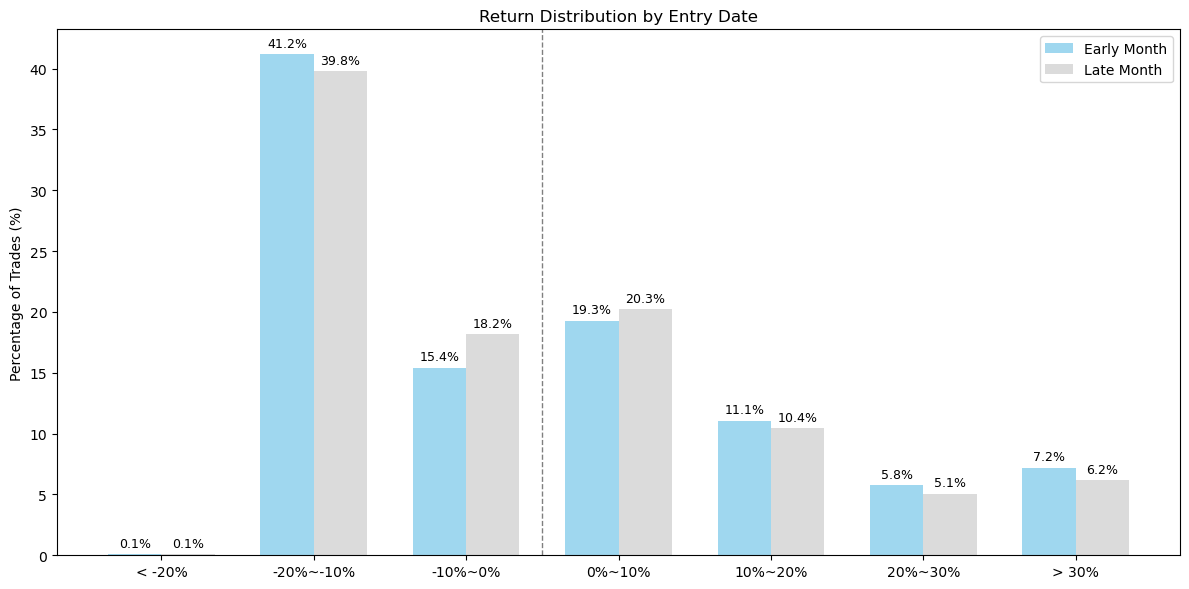

C:\Users\teraw_rp58jwl\AppData\Local\Temp\ipykernel_205328\1860005888.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_early_month', y='return', data=df_trades, palette=['lightgray', 'skyblue'])


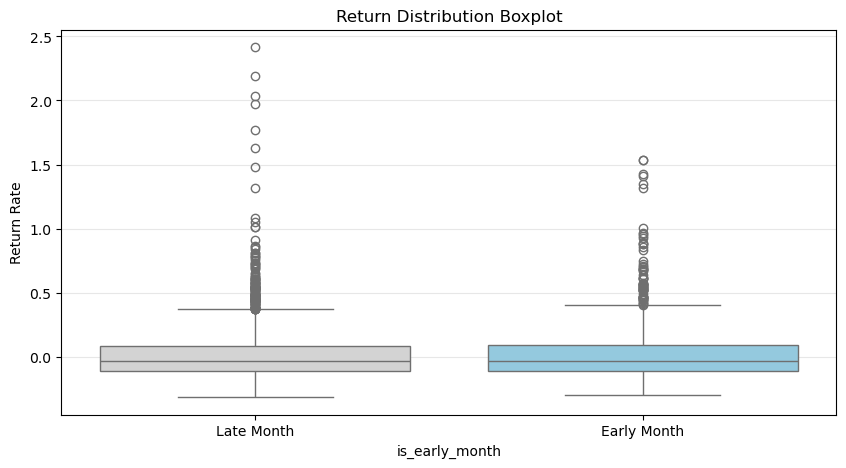

In [11]:
# ======================================
# 11. 獲利比例分佈統計 (Profit Distribution Analysis)
# 延續上一步的 'is_early_month' 標籤，進一步分析獲利分佈區間
# ======================================

if not df_trades.empty:
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 設定獲利區間 (bins)
    bins = [-np.inf, -0.2, -0.1, 0, 0.1, 0.2, 0.3, np.inf]
    labels = ['< -20%', '-20%~-10%', '-10%~0%', '0%~10%', '10%~20%', '20%~30%', '> 30%']
    
    # 將報酬率分組
    df_trades['return_group'] = pd.cut(df_trades['return'], bins=bins, labels=labels)
    
    # 1. 全體分佈
    dist_all = df_trades['return_group'].value_counts(normalize=True).sort_index()
    
    # 2. 上旬 (1-10日) 分佈
    dist_early = df_trades[df_trades['is_early_month']]['return_group'].value_counts(normalize=True).sort_index()
    
    # 3. 中下旬 (11-31日) 分佈
    dist_late = df_trades[~df_trades['is_early_month']]['return_group'].value_counts(normalize=True).sort_index()
    
    # --- 輸出文字統計 ---
    print("========== 獲利分佈統計 (佔比%) ==========")
    print(f"{'區間':<12} | {'全體':<8} | {'上旬 (1-10)':<12} | {'中下旬 (11-31)':<12}")
    print("-" * 55)
    
    for label in labels:
        val_all = dist_all.get(label, 0) * 100
        val_early = dist_early.get(label, 0) * 100
        val_late = dist_late.get(label, 0) * 100
        print(f"{label:<12} | {val_all:6.1f}% | {val_early:10.1f}% | {val_late:12.1f}%")
        
    print("-" * 55)
    
    # --- 視覺化繪圖 ---
    # 準備繪圖資料
    x = np.arange(len(labels))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(x - width/2, [dist_early.get(l, 0)*100 for l in labels], width, label='Early Month', color='skyblue', alpha=0.8)
    rects2 = ax.bar(x + width/2, [dist_late.get(l, 0)*100 for l in labels], width, label='Late Month', color='lightgray', alpha=0.8)
    
    ax.set_ylabel('Percentage of Trades (%)')
    ax.set_title('Return Distribution by Entry Date')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    ax.axvline(x=2.5, color='black', linestyle='--', linewidth=1, alpha=0.5) # 0% 分界線
    
    # 標示數值
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()
    
    # 進階：Boxplot 比較分佈型態
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='is_early_month', y='return', data=df_trades, palette=['lightgray', 'skyblue'])
    plt.xticks([0, 1], ['Late Month', 'Early Month'])
    plt.title('Return Distribution Boxplot')
    plt.ylabel('Return Rate')
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

else:
    print("無交易紀錄，無法進行分佈分析。")

### 9. 固定持有期策略 + 大盤濾網 + 營收濾網
進一步加入基本面濾網：
- **營收成長**：要求個股最近一個月營收年增率 (YoY) 必須大於 0，確保公司基本面具備成長動能。

### 9. 固定持有期策略 + 大盤濾網 + 營收濾網
進一步加入基本面濾網：
- **營收成長**：要求個股最近一個月營收年增率 (YoY) 必須大於 0，確保公司基本面具備成長動能。

In [12]:
# ======================================
# 9. 固定持有期策略回測 + 大盤濾網 + 營收成長濾網
# 
# 新增條件：
#   個股進場前，檢查「月營收年增率 (YOY)」是否 > 0
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# [新增] 抓取營收 YoY 資料
rev_yoy = data.get('monthly_revenue:去年同月增減(%)')[common_cols]

# [新增] 抓取大盤資料 (加權指數)
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定 (依照您提供的數據)
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 40 天
COOLING_OFF_DAYS = 5           # 進場冷卻期 5 天
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有 + 大盤濾網 + 營收濾網)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [修正] 大盤濾網條件
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        if isinstance(benchmark, pd.DataFrame):
             bm_val = benchmark.at[yesterday, benchmark.columns[0]]
        else:
             bm_val = benchmark.at[yesterday]
             
        if isinstance(benchmark_ma200, pd.DataFrame):
             ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]]
        else:
             ma_val = benchmark_ma200.at[yesterday]
             
        if pd.notna(bm_val) and pd.notna(ma_val):
            if bm_val <= ma_val:
                market_filter_pass = False
    
    if not market_filter_pass:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
        
        # [新增] 營收 YoY > 0 濾網
        # 檢查該股票昨日是否有營收數據，且 YoY > 0
        if stock_id in rev_yoy.columns:
            # 確保有資料
            if yesterday in rev_yoy.index:
                yoy_val = rev_yoy.at[yesterday, stock_id]
                # 若資料缺失 (NaN) 或 YoY <= 0 則跳過
                if pd.isna(yoy_val) or yoy_val <= 0:
                    continue
            else:
                # 當天沒資料
                continue
        else:
            # 整個欄位都沒有
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i,
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title="Cumulative PnL (Fixed 40d + Mkt + Rev>0)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

KeyError: "['6272', '6620', '6884', '7777', '7805', '7810', '8102'] not in index"

開始回測 (固定持有 + 大盤濾網 + 每月15日前進場)
期間: 2008-02-13 ~ 2025-12-19
參數: 停損=10.0%, 固定持有=40天, 冷卻=5天

總交易次數: 2768
總損益: 6,310,026
平均報酬率: 2.28%
勝率: 44.04%
平均持有天數: 30.6 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
2758,2330,2025-10-13,2025-12-09,1390.00,1480.0,Time Exit (40 days),6045.722775,0.061251,71,40
2759,8996,2025-10-14,2025-12-10,460.50,510.0,Time Exit (40 days),10379.479714,0.103854,217,40
2760,6603,2025-10-14,2025-12-10,19.65,23.4,Time Exit (40 days),18691.609428,0.186928,5088,40
2761,6139,2025-10-15,2025-12-11,418.00,528.0,Time Exit (40 days),25879.205605,0.259009,239,40
2762,2211,2025-10-15,2025-12-11,110.50,112.5,Time Exit (40 days),1474.173140,0.014756,904,40
2763,3002,2025-10-15,2025-12-11,20.25,27.3,Time Exit (40 days),34368.057205,0.343720,4937,40
2764,1795,2025-12-01,2025-12-11,316.00,283.0,Stop Loss (-10.0%),-10723.256970,-0.107372,316,8
2765,8358,2025-12-11,2025-12-16,288.00,247.0,Stop Loss (-10.0%),-14510.581413,-0.145178,347,3
2766,2308,2025-12-03,2025-12-17,997.00,890.0,Stop Loss (-10.0%),-10993.889750,-0.110254,100,10
2767,3653,2025-12-09,2025-12-17,3015.00,2705.0,Stop Loss (-10.0%),-10524.693300,-0.105766,33,6


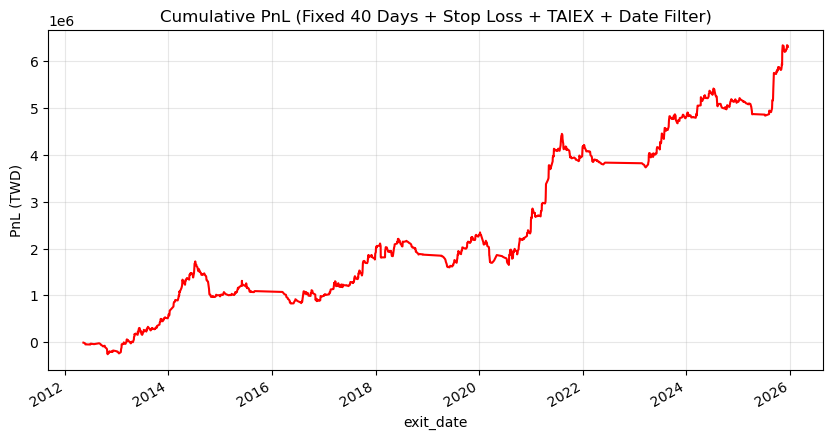

In [ ]:
# ======================================
# 9. 固定持有期策略回測 (Fixed Holding + Stop Loss) + 大盤濾網 + 日期濾網
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# [新增] 抓取大盤資料 (加權指數)
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 40 天
COOLING_OFF_DAYS = 5           # 進場冷卻期 5 天
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有 + 大盤濾網 + 每月15日前進場)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [修正] 大盤濾網條件
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        # benchmark 有可能有多個欄位 (雖然看起來像 Series)，為了保險使用 .iloc[0] 或 .item()
        # 情境 1: benchmark 是 DataFrame
        if isinstance(benchmark, pd.DataFrame):
             bm_val = benchmark.at[yesterday, benchmark.columns[0]]
        else:
             bm_val = benchmark.at[yesterday]
             
        if isinstance(benchmark_ma200, pd.DataFrame):
             ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]]
        else:
             ma_val = benchmark_ma200.at[yesterday]
             
        # 進行比較
        if pd.notna(bm_val) and pd.notna(ma_val):
            if bm_val <= ma_val:
                market_filter_pass = False
    
    # 如果大盤濾網未通過，則今天完全不開新倉
    if not market_filter_pass:
        continue

    # [新增] 限制每月 15 日前才進場 (包含 12 日)
    if today.day > 15:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i, # 紀錄 index 以計算天數
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 簡單繪製權益曲線
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title="Cumulative PnL (Fixed 40 Days + Stop Loss + TAIEX + Date Filter)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

開始回測 (固定持有 + 大盤濾網 + 每月15日前 + 排名前3)
期間: 2008-02-13 ~ 2025-12-19
參數: 停損=10.0%, 固定持有=40天, 冷卻=5天

總交易次數: 1841
總損益: 4,480,483
平均報酬率: 2.44%
勝率: 44.16%
平均持有天數: 30.3 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
1831,2344,2025-10-07,2025-12-04,40.75,57.8,Time Exit (40 days),41363.851401,0.413746,2453,40
1832,8046,2025-10-09,2025-12-08,267.50,270.0,Time Exit (40 days),601.800531,0.006031,373,40
1833,1605,2025-10-13,2025-12-09,30.05,30.7,Time Exit (40 days),1827.331877,0.018275,3327,40
1834,2313,2025-10-13,2025-12-09,83.20,84.5,Time Exit (40 days),1228.145903,0.012289,1201,40
1835,8996,2025-10-14,2025-12-10,460.50,510.0,Time Exit (40 days),10379.479714,0.103854,217,40
1836,6139,2025-10-15,2025-12-11,418.00,528.0,Time Exit (40 days),25879.205605,0.259009,239,40
1837,2211,2025-10-15,2025-12-11,110.50,112.5,Time Exit (40 days),1474.173140,0.014756,904,40
1838,8358,2025-12-11,2025-12-16,288.00,247.0,Stop Loss (-10.0%),-14510.581413,-0.145178,347,3
1839,2308,2025-12-03,2025-12-17,997.00,890.0,Stop Loss (-10.0%),-10993.889750,-0.110254,100,10
1840,1802,2025-12-03,2025-12-18,37.60,32.9,Stop Loss (-10.0%),-12786.456279,-0.127874,2659,11


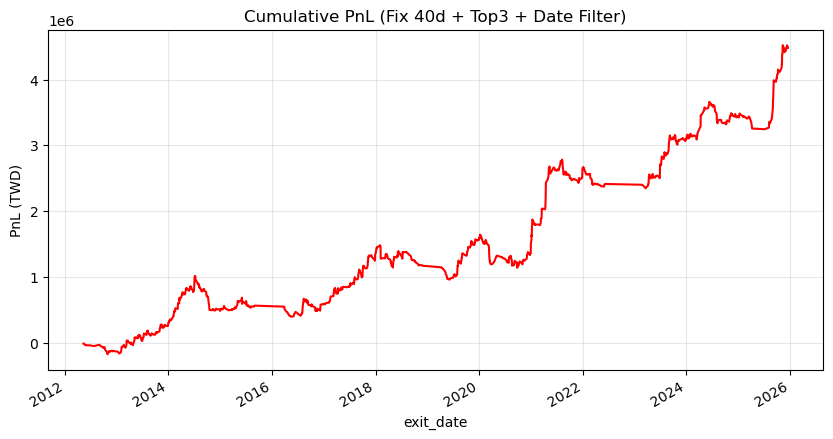

In [ ]:
# ======================================
# 9. 固定持有期策略回測 (Fixed Holding) + 大盤濾網 + 日期濾網 + 排名濾網
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# [新增] 抓取大盤資料 (加權指數)
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 2. 計算個股 200MA (進場濾網)
ma200 = close_.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1  # 手續費 1折
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10           # 下跌 10% 停損
FIXED_HOLDING_DAYS = 40        # 固定持有 40 天
COOLING_OFF_DAYS = 5           # 進場冷卻期 5 天
TOP_N_LIMIT = 3                # [新增] 每日只選排名前 3 名
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (固定持有 + 大盤濾網 + 每月15日前 + 排名前{TOP_N_LIMIT})")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"參數: 停損={STOP_LOSS_PCT*100}%, 固定持有={FIXED_HOLDING_DAYS}天, 冷卻={COOLING_OFF_DAYS}天")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        # 確保當日有報價
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        
        exit_reason = None
        
        # 1. 優先檢查停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 檢查是否持有期滿 (未停損才檢查)
        if not exit_reason:
            held_days = i - pos['entry_idx']
            if held_days >= FIXED_HOLDING_DAYS:
                exit_reason = f"Time Exit ({FIXED_HOLDING_DAYS} days)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,\
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': i - pos['entry_idx'] # 實際持有天數
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    
    # [修正] 大盤濾網條件
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        # benchmark 有可能有多個欄位 (雖然看起來像 Series)，為了保險使用 .iloc[0] 或 .item()
        # 情境 1: benchmark 是 DataFrame
        if isinstance(benchmark, pd.DataFrame):
             bm_val = benchmark.at[yesterday, benchmark.columns[0]]
        else:
             bm_val = benchmark.at[yesterday]
             
        if isinstance(benchmark_ma200, pd.DataFrame):
             ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]]
        else:
             ma_val = benchmark_ma200.at[yesterday]
             
        # 進行比較 (大盤 < 200MA 則不進場)
        if pd.notna(bm_val) and pd.notna(ma_val):
            if bm_val <= ma_val:
                market_filter_pass = False
    
    # 如果大盤濾網未通過，則今天完全不開新倉
    if not market_filter_pass:
        continue

    # [條件] 限制每月 15 日前才進場 (包含 15 日)
    if today.day > 15:
        continue

    # 取得當日候選名單
    candidates = signal_dict.get(yesterday, [])
    
    # [新增] 僅選取排名前 N 名 (假設 candidates 列表已排序)
    candidates = candidates[:TOP_N_LIMIT]
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 200MA 濾網
        if pd.isna(ma200.at[yesterday, stock_id]) or pd.isna(close_.at[yesterday, stock_id]):
            continue
        if close_.at[yesterday, stock_id] <= ma200.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        is_first_in_period = True
        if last_date is not None:
            try:
                last_idx = close_.index.get_loc(last_date)
                yest_idx = close_.index.get_loc(yesterday)
                if (yest_idx - last_idx) <= COOLING_OFF_DAYS:
                    is_first_in_period = False
            except:
                pass
        
        last_selected_date[stock_id] = yesterday
        
        if not is_first_in_period:
            continue
            
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            cost = entry_price * shares * (1 + FEE_RATE)
            
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i, # 紀錄 index 以計算天數
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 簡單繪製權益曲線
    import matplotlib.pyplot as plt
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="red", title=f"Cumulative PnL (Fix 40d + Top{TOP_N_LIMIT} + Date Filter)")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")

開始回測 (移動停利 + 40天低獲利強制出場)
期間: 2008-02-13 ~ 2025-12-29
出場邏輯: 1.硬停損 10%  2.獲利達 10% 後破 20MA 停利  3.持有 40 天獲利不足 5% 出場

總交易次數: 1429
總損益: 3,494,414
平均報酬率: 2.45%
勝率: 44.72%
平均持有天數: 30.8 天


,stock_id,entry_date,exit_date,entry_price,exit_price,reason,pnl,return,shares,held_days
1419,2408,2025-10-13,2025-11-21,93.5,140.0,20MA Trailing Stop,49223.950361,0.492408,1069,28
1420,3715,2025-11-13,2025-11-24,122.0,108.5,Stop Loss (-10.0%),-11349.985579,-0.113577,819,7
1421,5289,2025-11-13,2025-11-24,532.0,467.0,Stop Loss (-10.0%),-12443.607852,-0.125064,187,7
1422,6505,2025-11-10,2025-11-26,50.0,50.2,20MA Trailing Stop,70.207879,0.000702,1999,12
1423,1303,2025-11-10,2025-12-16,43.5,58.2,20MA Trailing Stop,33346.066010,0.333537,2298,26
1424,3443,2025-11-12,2025-12-16,1990.0,2020.0,20MA Trailing Stop,1168.428750,0.011741,50,24
1425,8358,2025-12-11,2025-12-16,288.0,247.0,Stop Loss (-10.0%),-14510.581413,-0.145178,347,3
1426,2211,2025-10-15,2025-12-17,110.5,102.5,"Eff. Exit (Day 40, <0% Profit)",-7537.418660,-0.075445,904,44
1427,2368,2025-11-13,2025-12-17,560.0,586.0,20MA Trailing Stop,4286.007710,0.042992,178,24
1428,6442,2025-11-14,2025-12-17,1010.0,1215.0,20MA Trailing Stop,19701.717875,0.199019,98,23


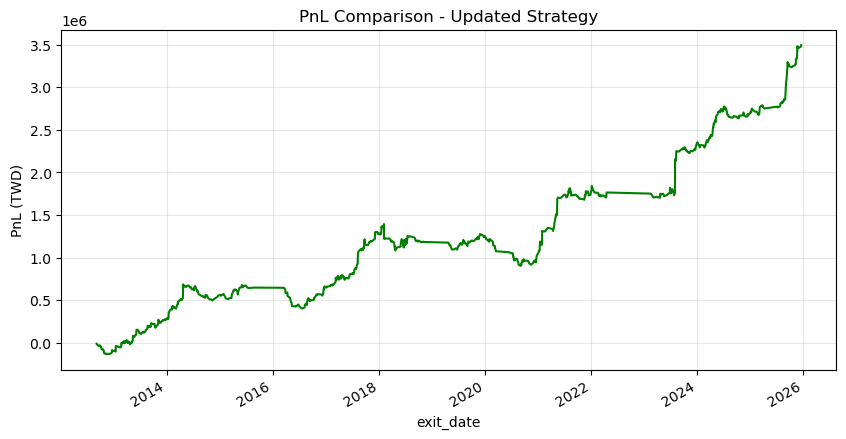

In [13]:
# ======================================
# 9. 優化策略：移動停利 + 啟動門檻 + 40天效率出場條件
# ======================================

# 1. 取得必要資料
open_ = data.get("price:開盤價")[common_cols]
close_ = close 

# 計算均線
ma60 = close_.rolling(60).mean()   # 進場濾網
ma20 = close_.rolling(20).mean()   # 出場停利線

# [確保] 抓取大盤資料
if 'benchmark' not in locals():
    benchmark = data.get('taiex_total_index:收盤指數')
    benchmark_ma200 = benchmark.rolling(200).mean()

# 3. 策略參數設定
CAPITAL_PER_TRADE = 100_000
FEE_RATE = 0.001425 * 0.1
TAX_RATE = 0.003

# --- 參數區 ---
STOP_LOSS_PCT = 0.10             # 硬停損 10%
PROFIT_THRESHOLD = 0.10          # 獲利 10% 啟動均線停利
TIME_EXIT_DAYS = 40              # 效率檢查天數
TIME_EXIT_PROFIT_LIMIT = 0    # 持有滿 40 天若獲利低於 5% 則出場
COOLING_OFF_DAYS = 5             # 冷卻期
# -------------

# 4. 初始化
positions = []
trade_history = []
last_selected_date = {}

# 設定回測期間
start_idx = 200
backtest_dates = close_.index[start_idx:]

print(f"開始回測 (移動停利 + 40天低獲利強制出場)")
print(f"期間: {backtest_dates[0].date()} ~ {backtest_dates[-1].date()}")
print(f"出場邏輯: 1.硬停損 10%  2.獲利達 10% 後破 20MA 停利  3.持有 40 天獲利不足 5% 出場")

signal_dict = selected_stocks

for i in range(1, len(backtest_dates)):
    today = backtest_dates[i]
    yesterday = backtest_dates[i-1]
    
    # --- A. 檢查出場 ---
    for pos in positions[:]:
        stock_id = pos['stock_id']
        
        if today not in close_.index or pd.isna(close_.at[today, stock_id]):
            continue
            
        current_close = close_.at[today, stock_id]
        current_ma20 = ma20.at[today, stock_id]
        held_days = i - pos['entry_idx'] # 目前已持有天數 (K棒數)
        
        # 計算當前報酬率
        current_return = (current_close / pos['entry_price']) - 1
        
        # 追蹤持有期間最高報酬
        if current_return > pos['max_return']:
            pos['max_return'] = current_return
        
        exit_reason = None
        
        # 1. 優先檢查硬停損
        if current_close < pos['entry_price'] * (1 - STOP_LOSS_PCT):
            exit_reason = f"Stop Loss (-{STOP_LOSS_PCT*100}%)"
            
        # 2. 獲利啟動 20MA 停利機制
        if not exit_reason and pos['max_return'] >= PROFIT_THRESHOLD:
            if pd.notna(current_ma20) and current_close < current_ma20:
                exit_reason = "20MA Trailing Stop"
        
        # 3. [新增] 效率出場條件：持有滿 40 天且獲利低於 5%
        if not exit_reason:
            if held_days >= TIME_EXIT_DAYS and current_return < TIME_EXIT_PROFIT_LIMIT:
                exit_reason = f"Eff. Exit (Day {TIME_EXIT_DAYS}, <{TIME_EXIT_PROFIT_LIMIT*100}% Profit)"
        
        if exit_reason:
            # 執行賣出
            revenue = current_close * pos['shares']
            cost = revenue * (FEE_RATE + TAX_RATE)
            pnl = revenue - cost - pos['cost']
            ret = pnl / pos['cost']
            
            trade_history.append({
                'stock_id': stock_id,
                'entry_date': pos['entry_date'],
                'exit_date': today,
                'entry_price': pos['entry_price'],
                'exit_price': current_close,
                'reason': exit_reason,
                'pnl': pnl,
                'return': ret,
                'shares': pos['shares'],
                'held_days': held_days 
            })
            positions.remove(pos)

    # --- B. 檢查進場 ---
    market_filter_pass = True
    if yesterday in benchmark.index and yesterday in benchmark_ma200.index:
        bm_val = benchmark.at[yesterday, benchmark.columns[0]] if isinstance(benchmark, pd.DataFrame) else benchmark.at[yesterday]
        ma_val = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]] if isinstance(benchmark_ma200, pd.DataFrame) else benchmark_ma200.at[yesterday]
        if pd.notna(bm_val) and pd.notna(ma_val) and bm_val <= ma_val:
            market_filter_pass = False
    
    if not market_filter_pass:
        continue

    # 每月進場窗口
    if today.day > 15 or today.day < 10:
        continue

    candidates = signal_dict.get(yesterday, [])
    
    for stock_id in candidates:
        if today not in open_.index or pd.isna(open_.at[today, stock_id]):
            continue
            
        # 60MA 進場濾網
        if pd.isna(ma60.at[yesterday, stock_id]) or close_.at[yesterday, stock_id] <= ma60.at[yesterday, stock_id]:
            continue
            
        # 冷卻期檢查
        last_date = last_selected_date.get(stock_id)
        if last_date is not None:
            try:
                if (close_.index.get_loc(yesterday) - close_.index.get_loc(last_date)) <= COOLING_OFF_DAYS:
                    continue
            except: pass
        
        if any(p['stock_id'] == stock_id for p in positions):
            continue
            
        # 執行買進
        entry_price = open_.at[today, stock_id]
        shares = int(CAPITAL_PER_TRADE / (entry_price * (1 + FEE_RATE)))
        
        if shares > 0:
            last_selected_date[stock_id] = yesterday
            cost = entry_price * shares * (1 + FEE_RATE)
            positions.append({
                'stock_id': stock_id,
                'entry_date': today,
                'entry_idx': i,
                'entry_price': entry_price,
                'shares': shares,
                'cost': cost,
                'max_return': 0 
            })

# ======================================
# 結果統計與分析
# ======================================
df_trades = pd.DataFrame(trade_history)

if not df_trades.empty:
    print(f"\n總交易次數: {len(df_trades)}")
    print(f"總損益: {df_trades['pnl'].sum():,.0f}")
    print(f"平均報酬率: {df_trades['return'].mean() * 100:.2f}%")
    print(f"勝率: {(df_trades['return'] > 0).mean() * 100:.2f}%")
    print(f"平均持有天數: {df_trades['held_days'].mean():.1f} 天")
    
    display(df_trades.tail(10))
    
    # 繪製權益曲線
    df_trades = df_trades.sort_values("exit_date")
    cumulative_pnl = df_trades.groupby("exit_date")["pnl"].sum().cumsum()
    plt.figure(figsize=(10, 5))
    cumulative_pnl.plot(color="green", title="PnL Comparison - Updated Strategy")
    plt.ylabel("PnL (TWD)")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("無交易紀錄")